In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from Utilities import pareto_front, compute_hypervolume
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

font = {'size': 16}
plt.rc('font', **font)

In [2]:
def plot_pf(non_dominated_points, rep, ax, l="", legend_uncertainty=True, uncertainty_color="peachpuff"):
    
    m = non_dominated_points #np.mean(rep, axis=1)
    std =  np.sqrt(np.var(rep, axis=1))
    max_data = m+std #np.max(non_dominated_points, axis=1)
    min_data = m-std #np.min(non_dominated_points, axis=1)
    
    ells = [Ellipse(xy=[m[i,0], m[i,1]], 
                    width=np.abs(max_data[i,0]-min_data[i,0]), 
                    height=np.abs(max_data[i,1]-min_data[i,1]))
            for i in range(m.shape[0])]

    index = 0
    for e in ells:
        ax.add_patch(e)
        
        if index==0 and legend_uncertainty:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor=uncertainty_color, edgecolor='silver', label=r'Uncertainty ($mean \pm std$)')
        else:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor=uncertainty_color, edgecolor='silver')
        index+=1
        
#         e.set_edgecolor('silver')
#     max_axes = np.max([max_data[:,0], max_data[:,1]])
#     ax.set_xlim(0, max_axes+.5)
#     ax.set_ylim(0, max_axes+.5)

    ax.scatter(non_dominated_points[:, 0], non_dominated_points[:, 1], s=50, 
               label="PF "+l, zorder=len(ells)+1)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    
#     ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
#     ax.scatter(solutions[:, 0], solutions[:, 1], color='orange', marker='+', zorder=len(ells)+2, label="Solutions")
    return ax

In [16]:
def plot_hypervolumen(file_name, initial_point, gp, motpe, gp_motpe, ref_point, title=""):
    
    hv_gp = []
    hv_motpe = []
    hv_gp_motpe = []
    for index in range(initial_point, gp.shape[0]):
        pf = pareto_front(gp[:index], index=True)
        pf = gp[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_gp.append(volumen)
        
        pf = pareto_front(motpe[:index], index=True)
        pf = motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_motpe.append(volumen)
        
        pf = pareto_front(gp_motpe[:index], index=True)
        pf = gp_motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_gp_motpe.append(volumen)
        
    print("    ", file_name, hv_gp[-1], hv_motpe[-1], hv_gp_motpe[-1])
#     print(hv_gp)
    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(hv_gp, label="GP")
    ax.plot(hv_motpe, label="MOTPE")
    ax.plot(hv_gp_motpe, label="GP_MOTPE")
    ax.set_xlabel("Iterations (Number of infill points)")
    ax.set_ylabel("Hypervolumen")
    plt.legend(loc="lower right")
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')
    plt.title(title)
    return np.asarray([0, hv_gp[-1], hv_motpe[-1], hv_gp_motpe[-1]])

In [4]:
def plot_function(file_name, gp, motpe, gp_motpe, rgp, rmotpe, rgp_motpe, tpf=[], xlim=[0, 1], ylim=[0,1], plot_uncertainty=True):
    rows = gp.shape[0]
    columns = gp.shape[1]
    rgp = rgp.reshape((rows, int(rgp.shape[0]/rows), columns))
    rmotpe = rmotpe.reshape((rows, int(rmotpe.shape[0]/rows), columns))
    rgp_motpe = rgp_motpe.reshape((rows, int(rgp_motpe.shape[0]/rows), columns))
    
    
    pf_gp = pareto_front(gp, index=True)
    rpf_gp = rgp[pf_gp]
    pf_gp = gp[pf_gp]
    
    pf_motpe = pareto_front(motpe, index=True)
    rpf_motpe = rmotpe[pf_motpe]
    pf_motpe = motpe[pf_motpe]
    
    pf_gp_motpe = pareto_front(gp_motpe, index=True)
    rpf_gp_motpe = rgp_motpe[pf_gp_motpe]
    pf_gp_motpe = gp_motpe[pf_gp_motpe]
    
    
    fig, ax = plt.subplots(figsize=(7,7))
    if len(tpf)!=0:
        ax.scatter(tpf[:,0], tpf[:,1], color='k', s=5, label="True PF")
    ax = plot_pf(pf_gp, rpf_gp, ax, l="GP", legend_uncertainty=False, uncertainty_color="lightblue")
    ax = plot_pf(pf_motpe, rpf_motpe, ax, legend_uncertainty=False, l="MOTPE")
    ax = plot_pf(pf_gp_motpe, rpf_gp_motpe, ax, l="GP_MOTPE", legend_uncertainty=False, uncertainty_color="lightgreen")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc='upper right', fontsize=18)
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')
    

In [5]:
# Load true PF
ZDT1 = pd.read_csv("PF_data\PF_functions\ZDT1.csv", sep=',', header=0).values
DTLZ6 = pd.read_csv("PF_data\PF_functions\DTLZ6.csv", sep=',', header=0).values
DTLZ7 = pd.read_csv("PF_data\PF_functions\DTLZ7.csv", sep=',', header=0).values
WFG4 = pd.read_csv("PF_data\PF_functions\WFG4.csv", sep=',', header=0).values

## Pareto front visualization

In [6]:
problem_names = ["ZDT1", "WFG4", "DTLZ7"]
algos = ["GP", "MOTPE", "GP_MOTPE"]

analytical_functions = {}

for id_algo in algos:
    
    problems = {}
    for id_problem in problem_names:
        l = 1.0
        
        if id_problem == "WFG4":
            g = 0.1
        else:
            g = 0.3
        
        if id_algo == "GP":
            path_file_rep = "../output/GP_sklearn/replications_GP_"+id_problem+".csv"
            path_file_obj = "../output/GP_sklearn/meanObjectives_GP_"+id_problem+".csv"
        elif id_algo == "GP_MOTPE":
            path_file_rep = "../output/parameter_exploration_GP_MOTPE/replications_GP_"+id_problem+"_gamma_"+str(g)+"_l_"+str(l)+".csv"
            path_file_obj = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_"+id_problem+"_gamma_"+str(g)+"_l_"+str(l)+".csv"
        else:
            path_file_rep = "../output/MOTPE_sklearn/replications_MOTPE_"+id_problem+"_g_"+str(g)+".csv"
            path_file_obj = "../output/MOTPE_sklearn/meanObjectives_MOTPE_"+id_problem+"_g_"+str(g)+".csv"
            
        data_file_r = pd.read_csv(path_file_rep, sep=',', header=0).values[:,1:]
        data_file_o = pd.read_csv(path_file_obj, sep=',', header=0).values[:,1:]
        
        problems[id_problem] ={
            "replications": np.asarray(data_file_r),
            "meanObjectives": np.asarray(data_file_o)
        }
    analytical_functions[id_algo] = problems

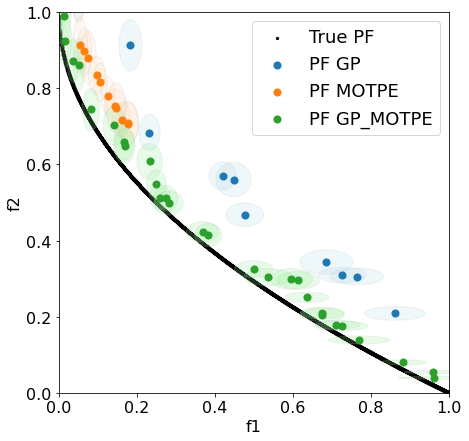

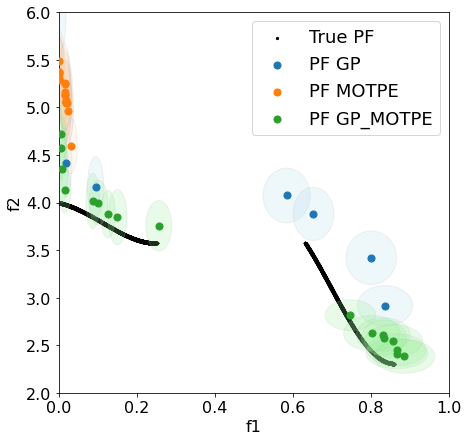

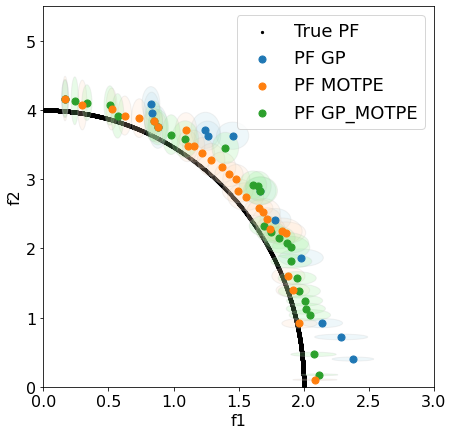

In [7]:
plot_function("..\output\plots\pf_ZDT1.pdf",
              analytical_functions["GP"]["ZDT1"]["meanObjectives"], 
              analytical_functions["MOTPE"]["ZDT1"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["ZDT1"]["meanObjectives"], 
              analytical_functions["GP"]["ZDT1"]["replications"][:,:2],  
              analytical_functions["MOTPE"]["ZDT1"]["replications"][:,:2],
              analytical_functions["GP_MOTPE"]["ZDT1"]["replications"][:,:2], 
              ZDT1, [0,1], [0,1])
plot_function("..\output\plots\pf_DTLZ7.pdf",
              analytical_functions["GP"]["DTLZ7"]["meanObjectives"], 
              analytical_functions["MOTPE"]["DTLZ7"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["DTLZ7"]["meanObjectives"], 
              analytical_functions["GP"]["DTLZ7"]["replications"][:,:2],  
              analytical_functions["MOTPE"]["DTLZ7"]["replications"][:,:2],
              analytical_functions["GP_MOTPE"]["DTLZ7"]["replications"][:,:2], 
              DTLZ7, [0,1], [2,6])
plot_function("..\output\plots\pf_WFG4.pdf",
              analytical_functions["GP"]["WFG4"]["meanObjectives"], 
              analytical_functions["MOTPE"]["WFG4"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["WFG4"]["meanObjectives"], 
              analytical_functions["GP"]["WFG4"]["replications"][:,:2],  
              analytical_functions["MOTPE"]["WFG4"]["replications"][:,:2],
              analytical_functions["GP_MOTPE"]["WFG4"]["replications"][:,:2], 
              WFG4, [0,3], [0,5.5])

## Hypervolume history

     ..\output\plots\hv_ZDT1.pdf 9.392808171532597 9.252253169641879 9.60114961964343
     ..\output\plots\hv_DTLZ7.pdf 19.014320314318972 18.383742069782414 19.46498247500797
     ..\output\plots\hv_WFG4.pdf 6.74740917527609 7.857019132139262 7.552937068162468


array([0.        , 6.74740918, 7.85701913, 7.55293707])

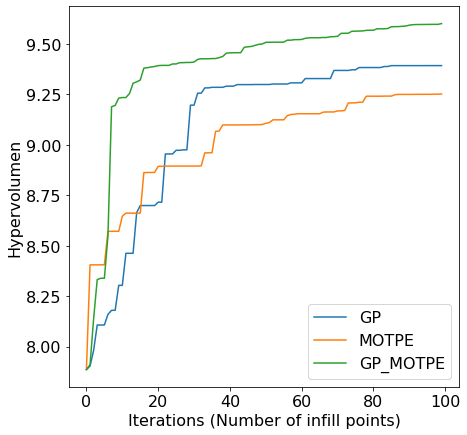

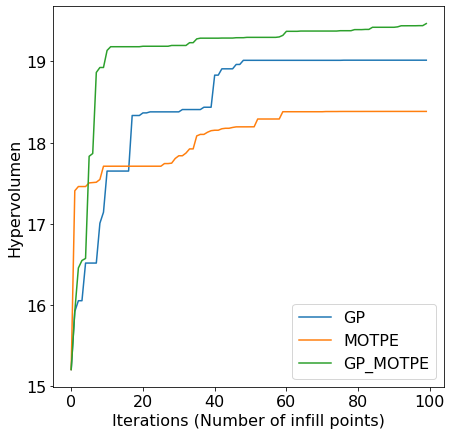

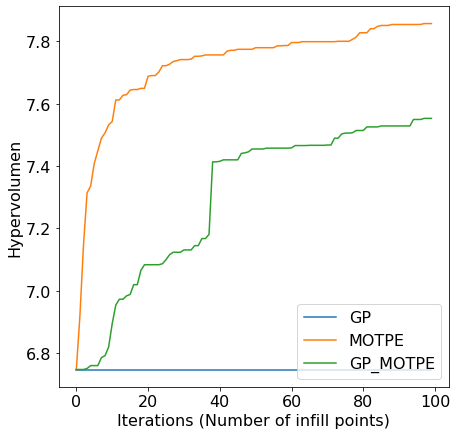

In [8]:
initial_point = 54

plot_hypervolumen("..\output\plots\hv_ZDT1.pdf", initial_point, 
                  analytical_functions["GP"]["ZDT1"]["meanObjectives"], 
              analytical_functions["MOTPE"]["ZDT1"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["ZDT1"]["meanObjectives"], [1, 10])
plot_hypervolumen("..\output\plots\hv_DTLZ7.pdf", initial_point, 
                  analytical_functions["GP"]["DTLZ7"]["meanObjectives"], 
              analytical_functions["MOTPE"]["DTLZ7"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["DTLZ7"]["meanObjectives"], [1, 23])
plot_hypervolumen("..\output\plots\hv_WFG4.pdf", initial_point, 
                  analytical_functions["GP"]["WFG4"]["meanObjectives"], 
              analytical_functions["MOTPE"]["WFG4"]["meanObjectives"],
              analytical_functions["GP_MOTPE"]["WFG4"]["meanObjectives"], [3, 5])

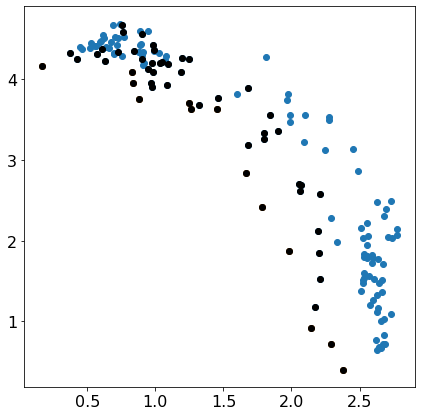

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(analytical_functions["GP"]["WFG4"]["meanObjectives"][:,0], 
           analytical_functions["GP"]["WFG4"]["meanObjectives"][:,1])


pf_gp = pareto_front(analytical_functions["GP"]["WFG4"]["meanObjectives"], index=True)
pf_gp = analytical_functions["GP"]["WFG4"]["meanObjectives"][pf_gp]
ax.scatter(pf_gp[:,0], pf_gp[:,1])

ax.scatter(analytical_functions["GP"]["WFG4"]["meanObjectives"][:54,0], 
           analytical_functions["GP"]["WFG4"]["meanObjectives"][:54,1], color='k')

## ML front

In [10]:
problem_names = ["MLP", "SVM", "DT"]
algos = ["GP", "MOTPE", "GP_MOTPE"]
# datasets_id = [997, 841, 1464, 53, 814, 770, 1524, 778, 41945, 820, 1460, 980, 819, 871, 41146, 847, 803]
datasets_id = [997, 841, 53, 814, 770, 778, 41945, 980, 871, 41146, 847, 803]

mlc_functions = {}

for id_algo in algos:
    
    problems = {}
    for id_problem in problem_names:
        l = 1
        g = 0.3
        
        datasets = {}
        for id_data in datasets_id:

            if id_algo == "GP":
                path_file_rep = "../output/GP_sklearn/replications_MOTPE_" + id_problem + "_" + str(id_data) + ".csv"
                path_file_val = "../output/GP_sklearn/meanObjectives_MOTPE_val_" + id_problem + "_" + str(id_data) + ".csv"
                path_file_test = "../output/GP_sklearn/meanObjectives_MOTPE_test_" + id_problem + "_" + str(id_data) + ".csv"
                path_file_train = "../output/GP_sklearn/training_MOTPE_" + id_problem + "_" + str(id_data) + ".csv"
            elif id_algo == "GP_MOTPE":
                path_file_rep = "../output/parameter_exploration_GP_MOTPE/replications_GP_MOTPE_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
                path_file_val = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_MOTPE_val_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
                path_file_test = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_MOTPE_test_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
                path_file_train = "../output/parameter_exploration_GP_MOTPE/training_GP_MOTPE_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
            else:
                path_file_rep = "../output/MOTPE_sklearn/replications_MOTPE_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
                path_file_val = "../output/MOTPE_sklearn/meanObjectives_MOTPE_val_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
                path_file_test = "../output/MOTPE_sklearn/meanObjectives_MOTPE_test_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
                path_file_train = "../output/MOTPE_sklearn/training_MOTPE_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
                
            data_file_r = pd.read_csv(path_file_rep, sep=',', header=0).values[:,1:]
            data_file_v = pd.read_csv(path_file_val, sep=',', header=0).values[:,1:]
            data_file_t = pd.read_csv(path_file_test, sep=',', header=0).values[:,1:]
            data_file_tr = pd.read_csv(path_file_train, sep=',', header=0).values[:,1:]
#             print(data_file_r.shape, data_file_v.shape, data_file_t.shape)
            
            datasets[id_data] ={
                "replications": np.asarray(data_file_r),
                "meanObjectivesVal": np.asarray(data_file_v),
                "meanObjectivesTest": np.asarray(data_file_t),
                "meanObjectivesTrain": np.asarray(data_file_tr)
            }
        
        problems[id_problem] = datasets
    mlc_functions[id_algo] = problems



# # Regression problems
# problem_namesr = ["MLPr", "SVMr", "DTr"]
# datasets_idr = [189, 507, 504, 529, 42636, 550, 23516]
# mlr_functions = {}

# for id_algo in algos:
    
#     problems = {}
#     for id_problem in problem_namesr:
#         l = 1
#         g = 0.3
        
#         datasets = {}
#         for id_data in datasets_idr:

#             if id_algo == "GP":
#                 path_file_rep = "../output/GP_sklearn/replications_GP_" + id_problem + "_" + str(id_data) + ".csv"
#                 path_file_val = "../output/GP_sklearn/meanObjectives_GP_val_" + id_problem + "_" + str(id_data) + ".csv"
#                 path_file_test = "../output/GP_sklearn/meanObjectives_GP_test_" + id_problem + "_" + str(id_data) + ".csv"
#             elif id_algo == "GP_MOTPE":
#                 path_file_rep = "../output/parameter_exploration_GP_MOTPE/replications_GP_MOTPE_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
#                 path_file_val = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_MOTPE_val_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
#                 path_file_test = "../output/parameter_exploration_GP_MOTPE/meanObjectives_GP_MOTPE_test_"+id_problem+"_" + str(id_data)+"_gamma_"+str(g)+"_l_"+str(l)+"_IT_99.csv"
#             else:
#                 path_file_rep = "../output/MOTPE_sklearn/replications_MOTPE_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
#                 path_file_val = "../output/MOTPE_sklearn/meanObjectives_MOTPE_val_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"
#                 path_file_test = "../output/MOTPE_sklearn/meanObjectives_MOTPE_test_" + id_problem + "_" + str(id_data)+"_g_"+str(g)+".csv"

#             data_file_r = pd.read_csv(path_file_rep, sep=',', header=0).values[:,1:]
#             data_file_v = pd.read_csv(path_file_val, sep=',', header=0).values[:,1:]
#             data_file_t = pd.read_csv(path_file_test, sep=',', header=0).values[:,1:]
# #             print(data_file_r.shape, data_file_v.shape, data_file_t.shape)
            
#             datasets[id_data] ={
#                 "replications": np.asarray(data_file_r),
#                 "meanObjectivesVal": np.asarray(data_file_v),
#                 "meanObjectivesTest": np.asarray(data_file_t)
#             }
        
#         problems[id_problem] = datasets
#     mlr_functions[id_algo] = problems

In [11]:
def plot_ML_exploration(file_name, model, initial_points, xlim=[0, 1], ylim=[0,1]):
    pf_model = pareto_front(model, index=True)
    pf_model = model[pf_model]


    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(pf_model[:, 0], -pf_model[:, 1], s=100, label="Observed Pareto front", color='k', facecolors='none', linewidth=2)
    ax.scatter(model[initial_points:, 0], -model[initial_points:, 1], s=90, label="Infill points", marker='x', color='orange')
    ax.scatter(model[:initial_points, 0], -model[:initial_points, 1], s=90, label="Initial design", marker='*', color='blue')

    ax.set_xlabel("Error")
    ax.set_ylabel("Recall")
    ax.set_xlim([0.2, 0.6])
#     ax.set_ylim(ylim)
    ax.legend(loc='upper left', fontsize=18)
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')

<ipython-input-11-6d0f559e3184>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,8))


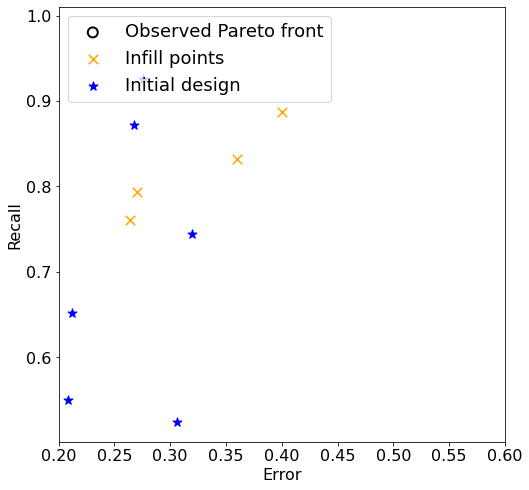

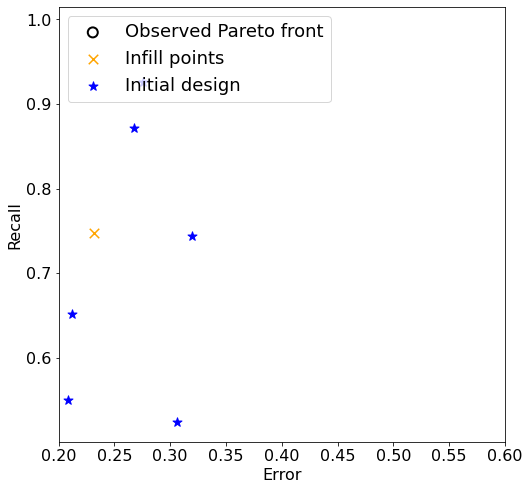

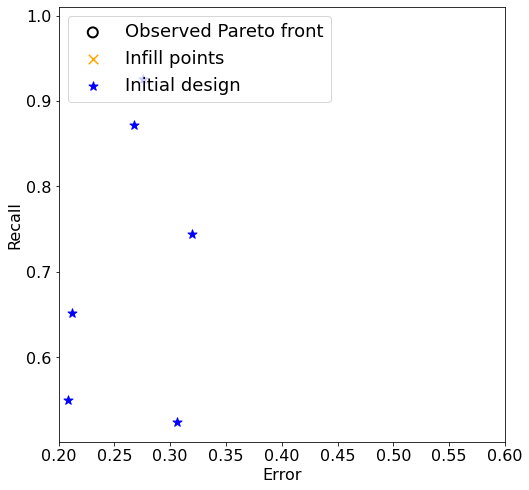

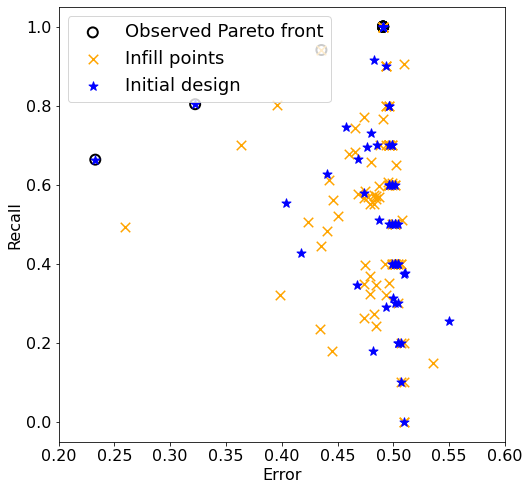

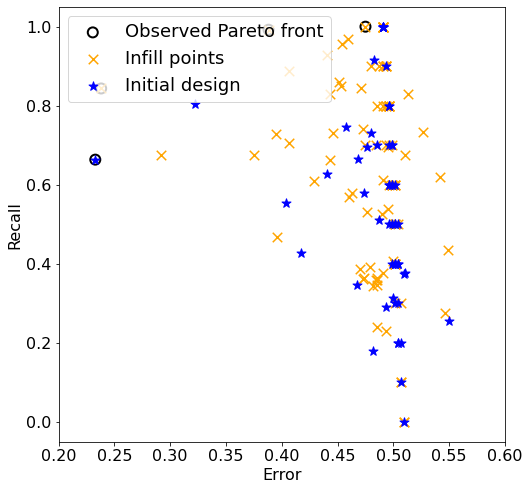

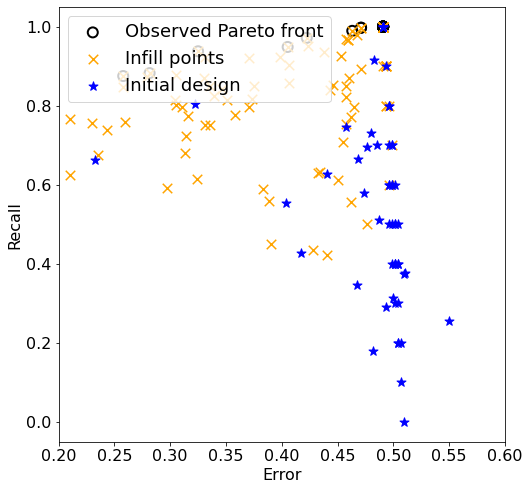

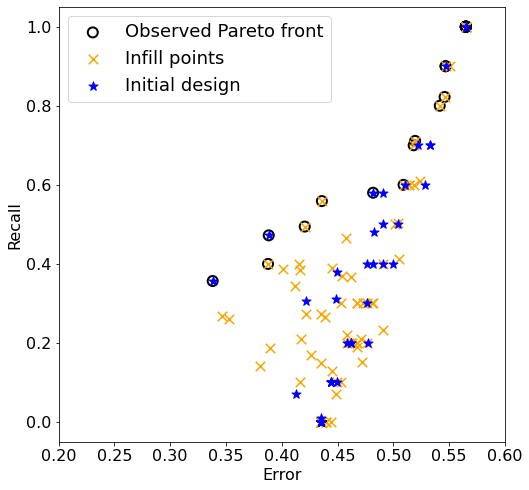

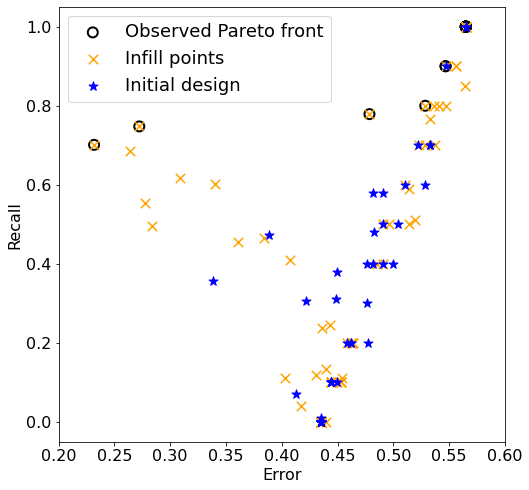

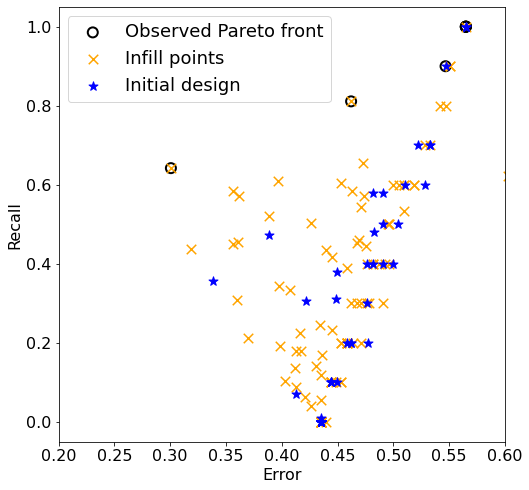

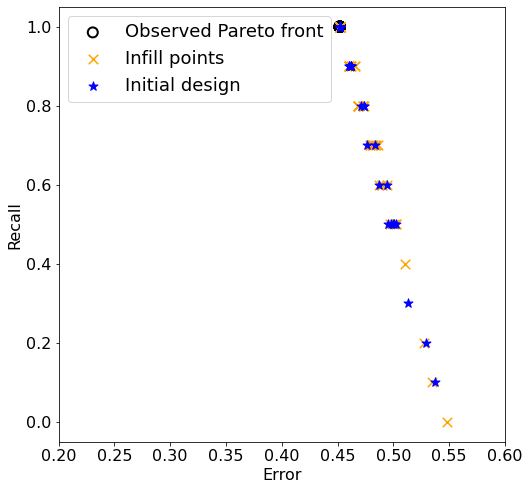

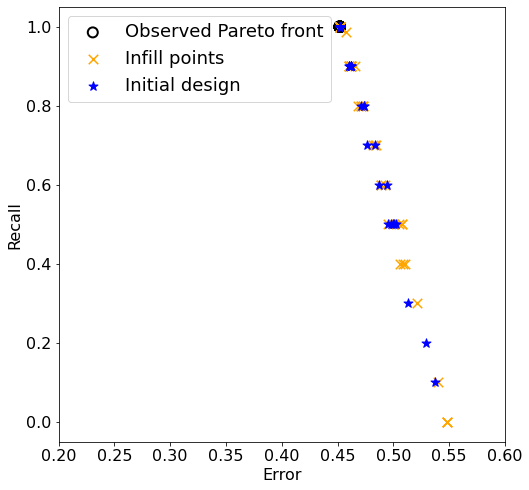

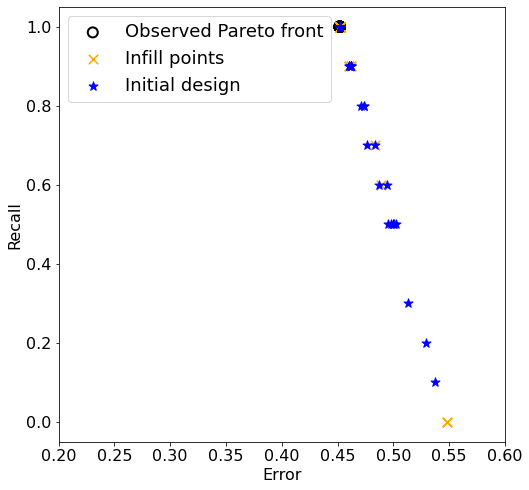

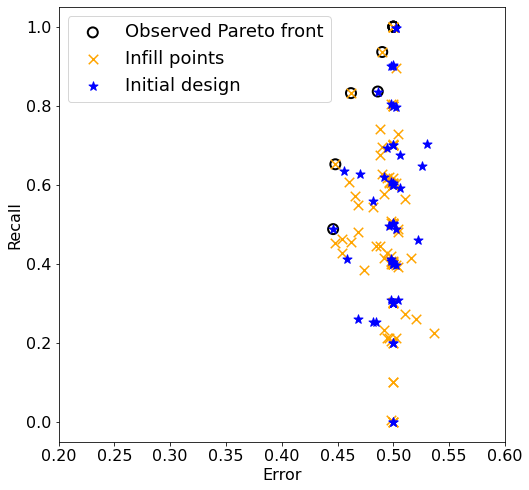

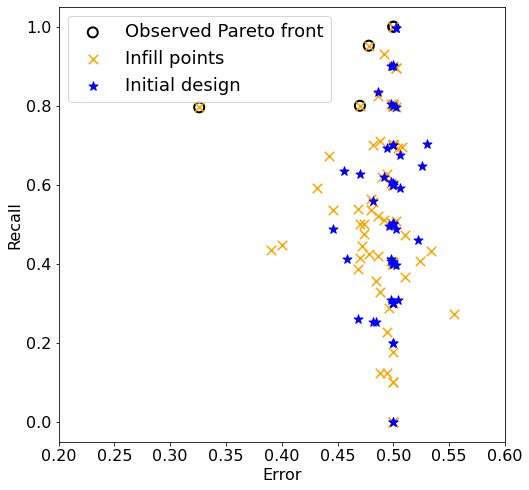

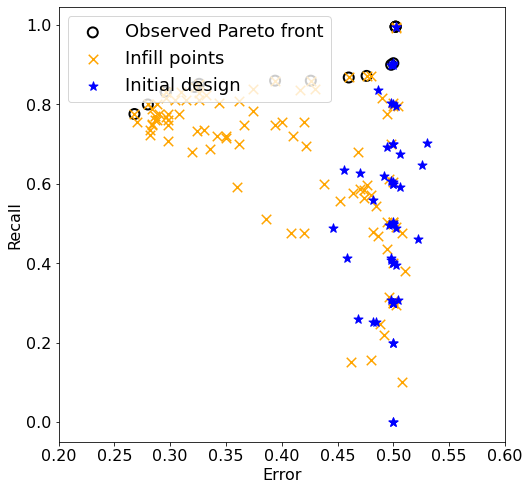

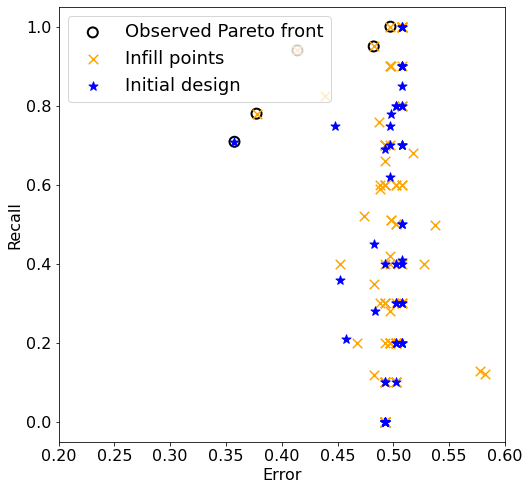

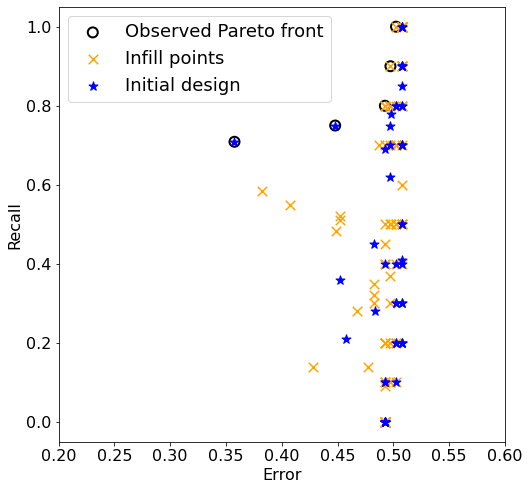

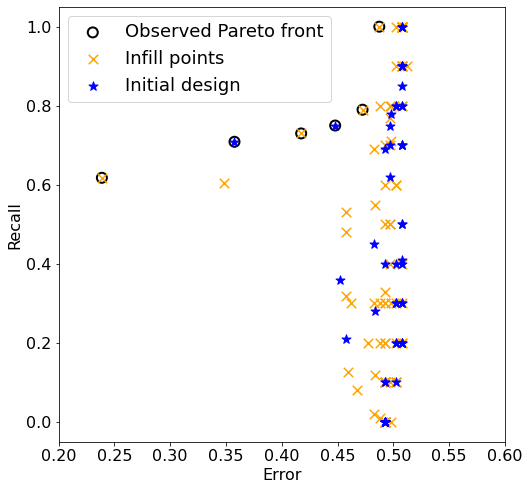

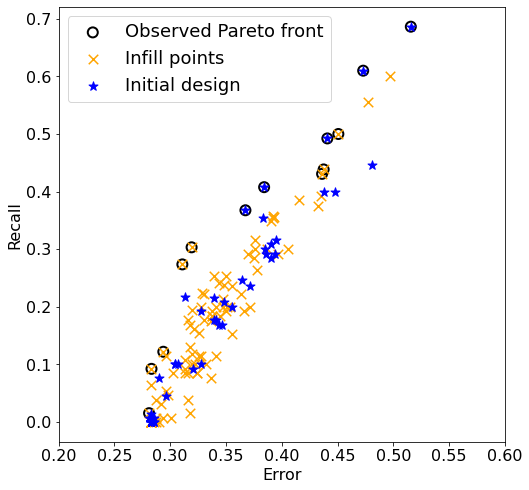

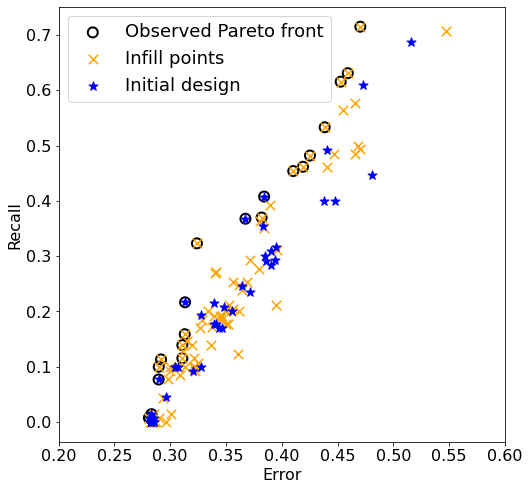

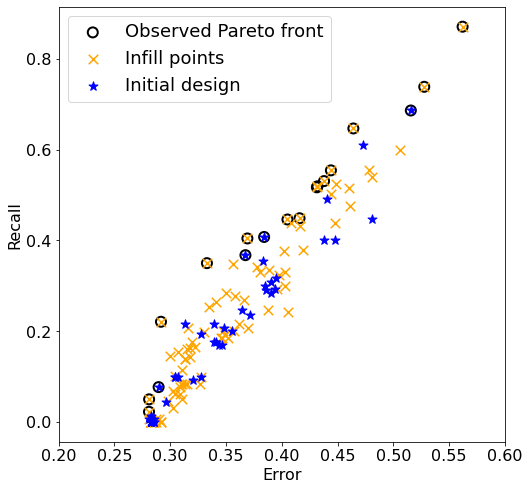

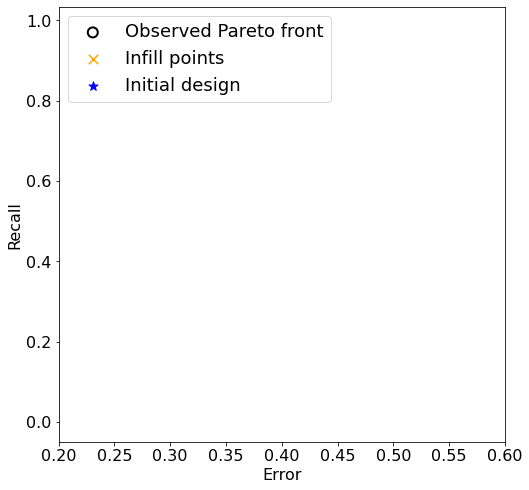

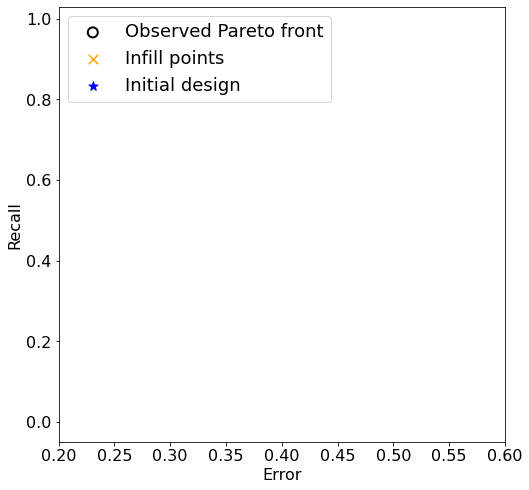

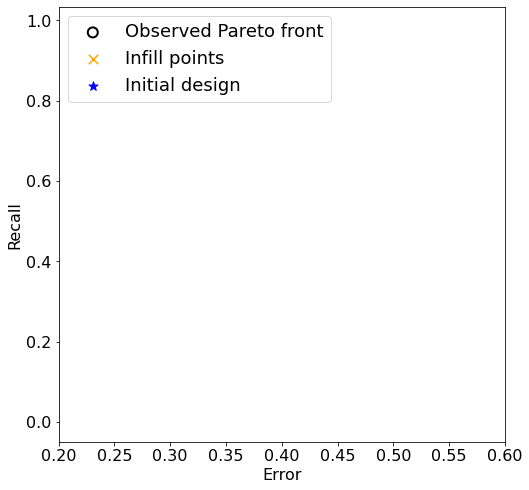

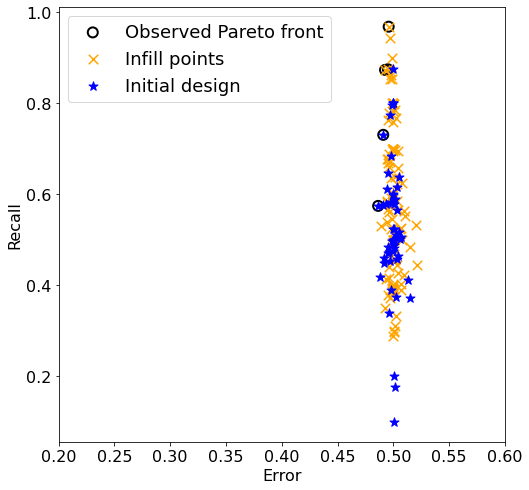

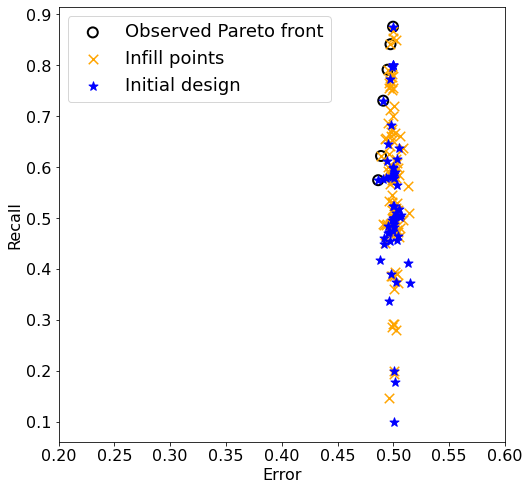

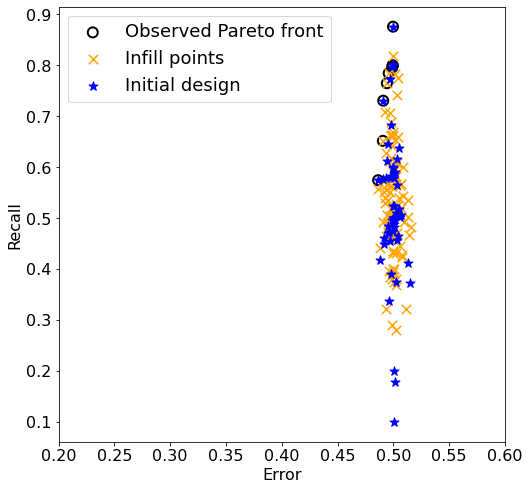

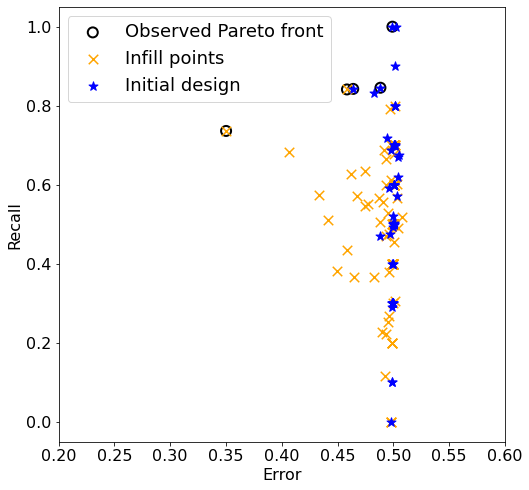

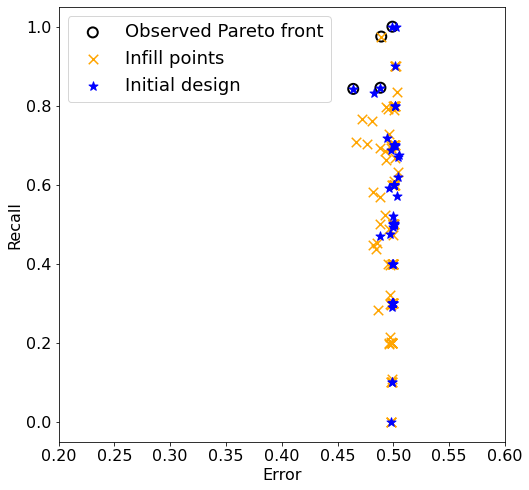

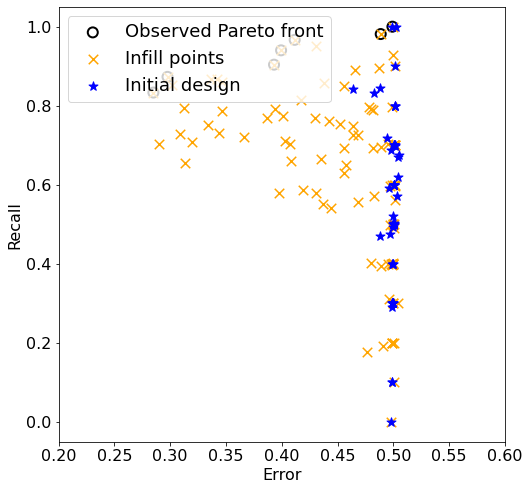

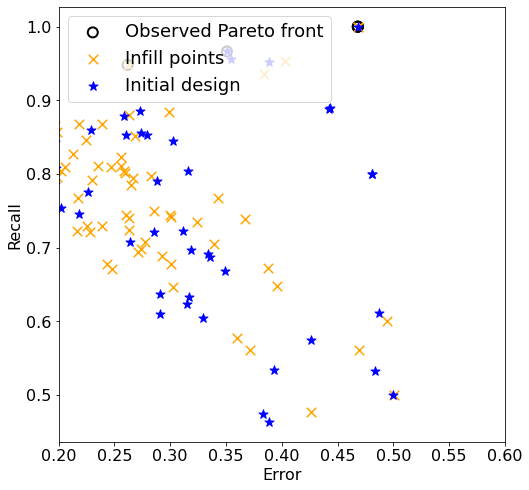

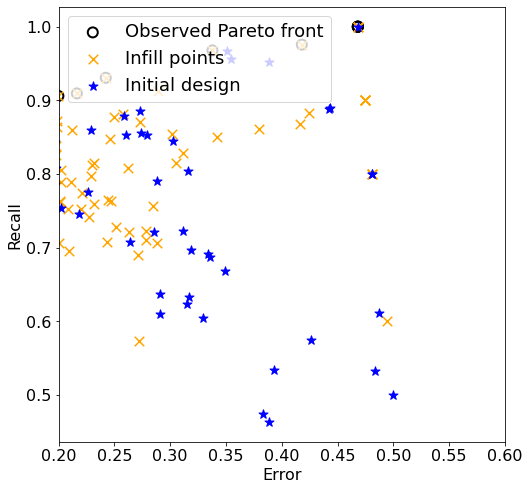

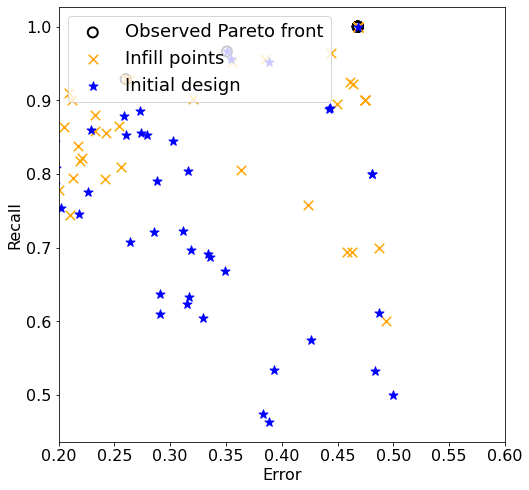

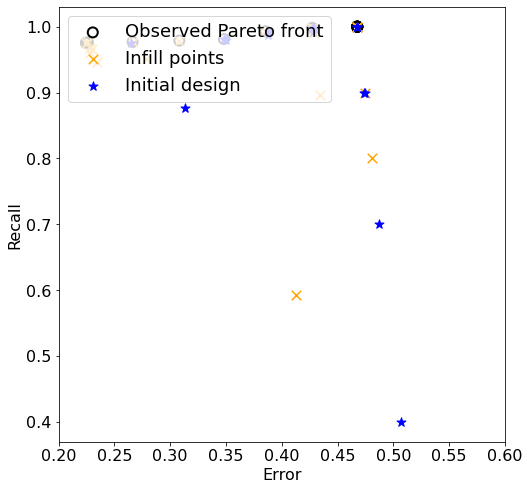

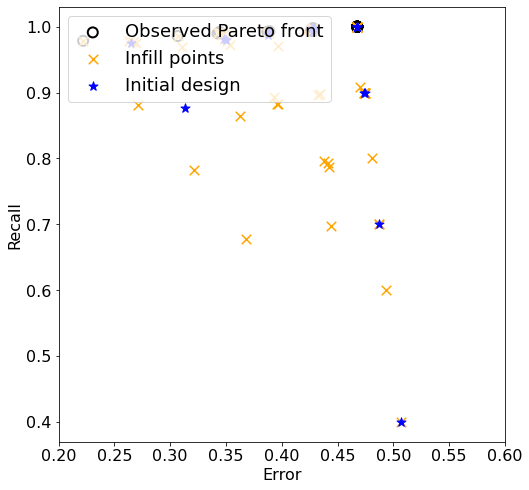

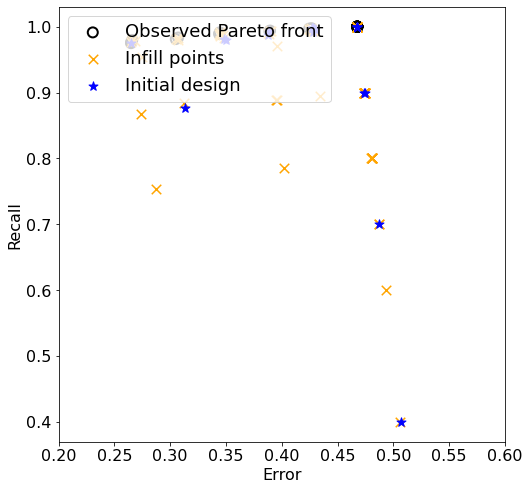

In [12]:
for id_data in datasets_id:
    plot_ML_exploration("..\output\plots\exploration_gp_MLP_"+str(id_data)+".pdf", 
                        mlc_functions["GP"]["MLP"][id_data]["meanObjectivesVal"],
                        54, xlim=[0.05, 0.6], ylim=[0, 1])
#     plot_ML_exploration("..\output\plots\exploration_gp_SVM_"+str(id_data)+".pdf", 
#                         mlc_functions["GP"]["SVM"][id_data]["meanObjectivesVal"], 
#                         21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_gp_DT_"+str(id_data)+".pdf", 
#                         mlc_functions["GP"]["DT"][id_data]["meanObjectivesVal"], 
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

    plot_ML_exploration("..\output\plots\exploration_gp_motpe_ML_"+str(id_data)+".pdf", 
                        mlc_functions["GP_MOTPE"]["MLP"][id_data]["meanObjectivesVal"], 
                        54, xlim=[0.05, 0.6], ylim=[0, 1])
#     plot_ML_exploration("..\output\plots\exploration_gp_motpe_SVM_"+str(id_data)+".pdf", 
#                         mlc_functions["GP_MOTPE"]["SVM"][id_data]["meanObjectivesVal"],
#                         21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_gp_motpe_DT_"+str(id_data)+".pdf", 
#                         mlc_functions["GP_MOTPE"]["DT"][id_data]["meanObjectivesVal"],
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

    plot_ML_exploration("..\output\plots\exploration_motpe_ML_"+str(id_data)+".pdf", 
                        mlc_functions["MOTPE"]["MLP"][id_data]["meanObjectivesVal"],
                        54, xlim=[0.05, 0.6], ylim=[0, 1])
#     plot_ML_exploration("..\output\plots\exploration_motpe_SVM_"+str(id_data)+".pdf", 
#                         mlc_functions["MOTPE"]["SVM"][id_data]["meanObjectivesVal"],
#                         21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_motpe_DT_"+str(id_data)+".pdf", 
#                         mlc_functions["MOTPE"]["DT"][id_data]["meanObjectivesVal"], 
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

In [13]:
for id_data in datasets_idr:
#     plot_ML_exploration("..\output\plots\exploration_gp_MLPr.pdf", 
#                         mlr_functions["GP"]["MLPr"][id_data]["meanObjectivesVal"],
#                         54, xlim=[0.05, 0.6], ylim=[0, 1])
    plot_ML_exploration("..\output\plots\exploration_gp_SVMr.pdf", 
                        mlr_functions["GP"]["SVMr"][id_data]["meanObjectivesVal"], 
                        21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_gp_DTr.pdf", 
#                         mlr_functions["GP"]["DTr"][id_data]["meanObjectivesVal"], 
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

#     plot_ML_exploration("..\output\plots\exploration_gp_motpe_MLPr.pdf", 
#                         mlc_functions["GP_MOTPE"]["MLP"][id_data]["meanObjectivesVal"], 
#                         54, xlim=[0.05, 0.6], ylim=[0, 1])
    plot_ML_exploration("..\output\plots\exploration_gp_motpe_SVMr.pdf", 
                        mlr_functions["GP_MOTPE"]["SVMr"][id_data]["meanObjectivesVal"],
                        21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_gp_motpe_DTr.pdf", 
#                         mlr_functions["GP_MOTPE"]["DTr"][id_data]["meanObjectivesVal"],
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

#     plot_ML_exploration("..\output\plots\exploration_motpe_MLPr.pdf", 
#                         mlr_functions["MOTPE"]["MLPr"][id_data]["meanObjectivesVal"],
#                         54, xlim=[0.05, 0.6], ylim=[0, 1])
    plot_ML_exploration("..\output\plots\exploration_motpe_SVMr.pdf", 
                        mlr_functions["MOTPE"]["SVMr"][id_data]["meanObjectivesVal"],
                        21, xlim=[0.05, 0.8], ylim=[-0.02, .9])
#     plot_ML_exploration("..\output\plots\exploration_motpe_DTr.pdf", 
#                         mlr_functions["MOTPE"]["DTr"][id_data]["meanObjectivesVal"], 
#                         54, xlim=[0.1, 0.45], ylim=[0.2, .9])

NameError: name 'datasets_idr' is not defined

In [ ]:
# seeds = [4554, 98, 5548, 139, 124, 85669, 147, 23,458,123,45,8]
# np.sort(seeds)

In [14]:
def plot_ML_function(file_name, gp, motpe, gp_motpe):
    pf_gp = pareto_front(gp, index=True)
    pf_gp = gp[pf_gp]

    pf_motpe = pareto_front(motpe, index=True)
    pf_motpe = motpe[pf_motpe]

    pf_gp_motpe = pareto_front(gp_motpe, index=True)
    pf_gp_motpe = gp_motpe[pf_gp_motpe]


    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(pf_gp[:, 0], -pf_gp[:, 1], s=50, label="Observed PF GP")
    ax.scatter(pf_motpe[:, 0], -pf_motpe[:, 1], s=50, label="Observed PF MOTPE")
    ax.scatter(pf_gp_motpe[:, 0], -pf_gp_motpe[:, 1], s=50, label="Observed PF GP_MOTPE")

    ax.set_xlabel("Error")
    ax.set_ylabel("Recall")
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ax.legend(loc='lower right')
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')

In [ ]:
# for id_data in datasets_id:
#     plot_ML_function("..\output\plots\pf_MLP.pdf", 
#                      mlc_functions["GP"]["MLP"][id_data]["meanObjectivesVal"],
#                      mlc_functions["MOTPE"]["MLP"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["GP_MOTPE"]["MLP"][id_data]["meanObjectivesVal"])
#     plot_ML_function("..\output\plots\pf_SVM.pdf", 
#                      mlc_functions["GP"]["SVM"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["MOTPE"]["SVM"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["GP_MOTPE"]["SVM"][id_data]["meanObjectivesVal"])
#     plot_ML_function("..\output\plots\pf_DT.pdf", 
#                      mlc_functions["GP"]["DT"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["MOTPE"]["DT"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["GP_MOTPE"]["DT"][id_data]["meanObjectivesVal"])
    
for id_data in datasets_idr:
    plot_ML_function("..\output\plots\pf_MLPr.pdf", 
                     mlr_functions["GP"]["MLPr"][id_data]["meanObjectivesVal"],
                     mlr_functions["MOTPE"]["MLPr"][id_data]["meanObjectivesVal"], 
                     mlr_functions["GP_MOTPE"]["MLPr"][id_data]["meanObjectivesVal"])
    plot_ML_function("..\output\plots\pf_SVMr.pdf", 
                     mlr_functions["GP"]["SVMr"][id_data]["meanObjectivesVal"], 
                     mlr_functions["MOTPE"]["SVMr"][id_data]["meanObjectivesVal"], 
                     mlr_functions["GP_MOTPE"]["SVMr"][id_data]["meanObjectivesVal"])
    plot_ML_function("..\output\plots\pf_DTr.pdf", 
                     mlr_functions["GP"]["DTr"][id_data]["meanObjectivesVal"], 
                     mlr_functions["MOTPE"]["DTr"][id_data]["meanObjectivesVal"], 
                     mlr_functions["GP_MOTPE"]["DTr"][id_data]["meanObjectivesVal"])

In [ ]:
mlc_functions["GP"].keys()

997
     ..\output\plots\hv_MLP.pdf 0.9554884057971015 0.9672384057971015 0.9713061594202897
841
     ..\output\plots\hv_MLP.pdf 0.7115672277860643 0.8109041835357625 0.7412259393422829
53
     ..\output\plots\hv_MLP.pdf 0.5597683982683983 0.6237753727753728 0.6875461760461761
814
     ..\output\plots\hv_MLP.pdf 0.5480796586059743 0.5480796586059743 0.5480796586059743
770
     ..\output\plots\hv_MLP.pdf 0.542776 0.6945039999999999 0.6419679999999999
778
     ..\output\plots\hv_MLP.pdf 0.6237113756613757 0.6808719576719577 0.6034806878306878
41945
     ..\output\plots\hv_MLP.pdf 0.4237941059865204 0.4569032285937929 0.44640569883400594
980
     ..\output\plots\hv_MLP.pdf 0.9803653121664556 0.9796782027650921 0.9740031679077337
871
     ..\output\plots\hv_MLP.pdf 0.4948601733902669 0.4475981778255397 0.4478016953373138
41146
     ..\output\plots\hv_MLP.pdf 0.6149608769515291 0.696732989440531 0.5317773491351337
847
     ..\output\plots\hv_MLP.pdf 0.8163378801129457 0.8236726328598953 0.8

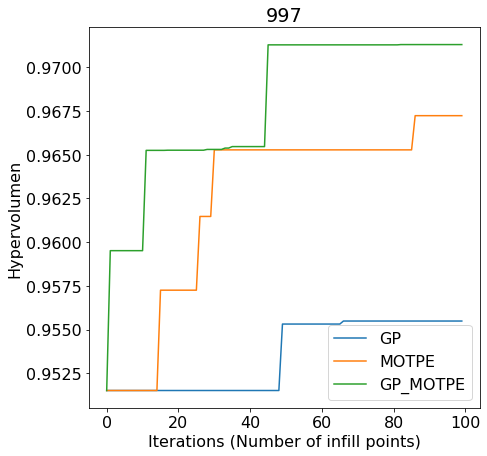

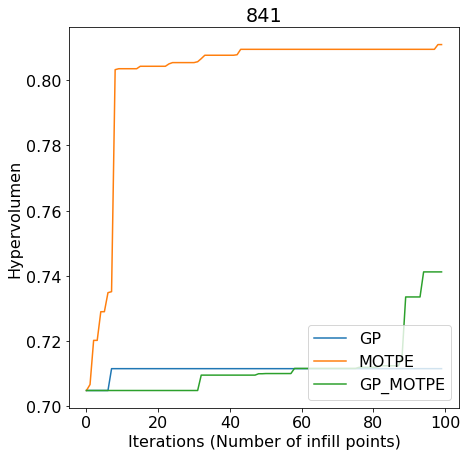

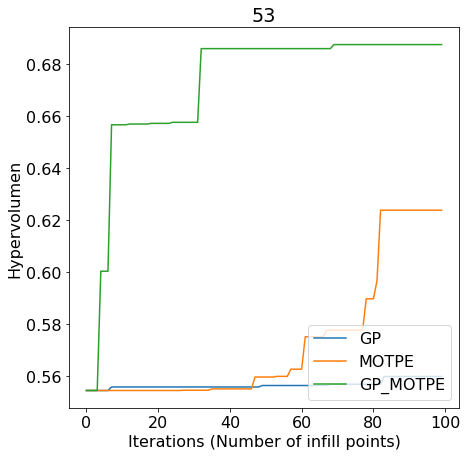

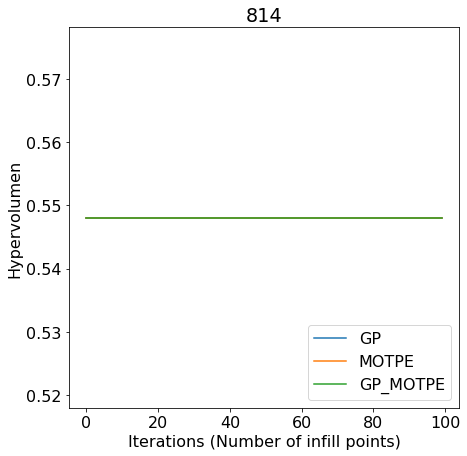

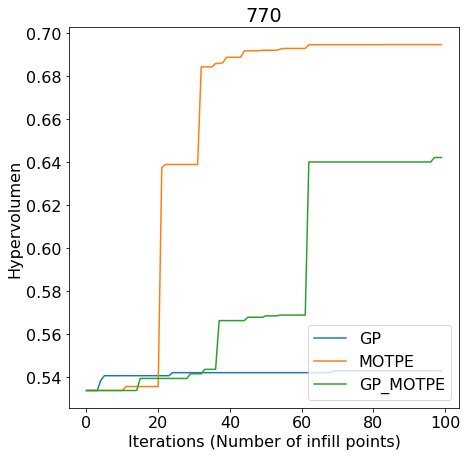

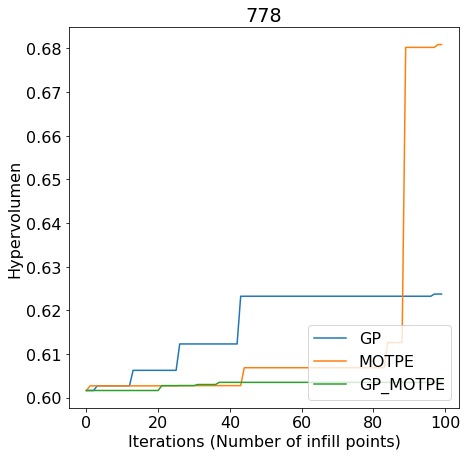

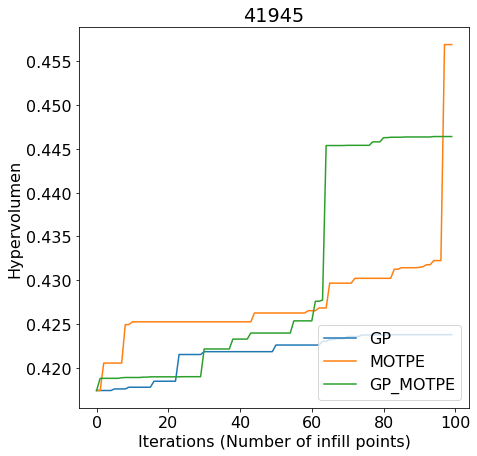

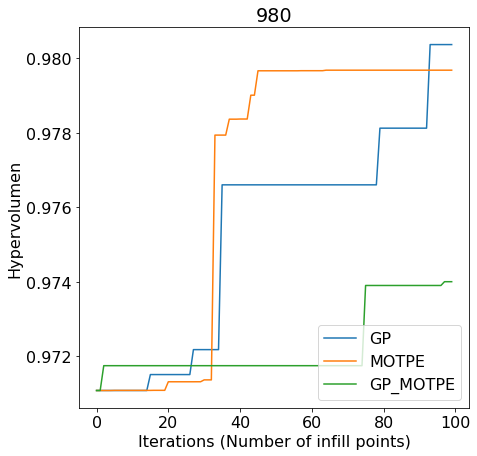

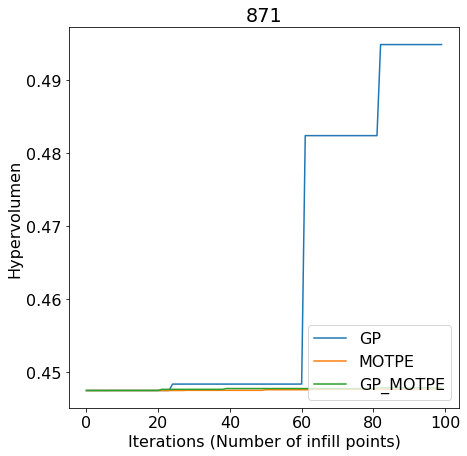

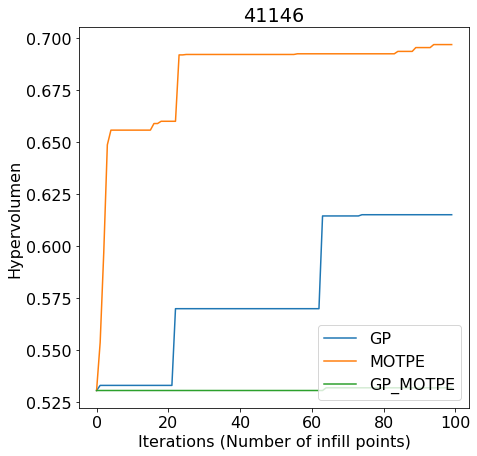

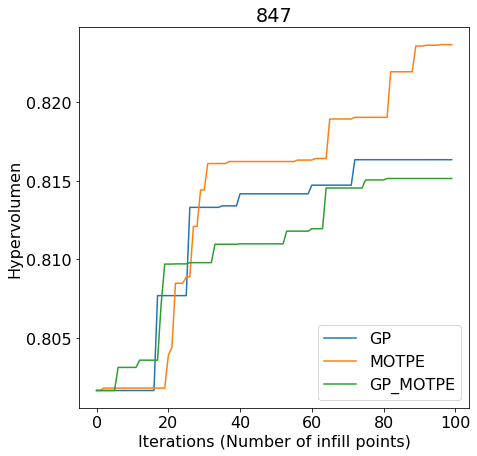

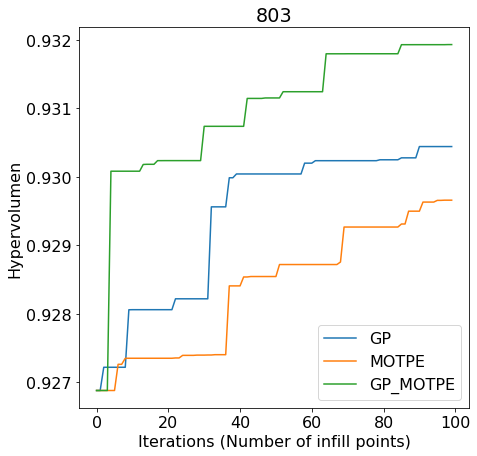

In [18]:
final_hv = []
# 0-MLP, 1-SVM, 2-DT
# 0-GP, 1-MOTPE, 2-GP_MOTPE

for id_data in datasets_id:
    print(id_data)
    hv = plot_hypervolumen("..\output\plots\hv_MLP.pdf", 54, 
                      mlc_functions["GP"]["MLP"][id_data]["meanObjectivesVal"],
                     mlc_functions["MOTPE"]["MLP"][id_data]["meanObjectivesVal"], 
                     mlc_functions["GP_MOTPE"]["MLP"][id_data]["meanObjectivesVal"], 
                      [1, 0], title=id_data)
    k = np.asarray([[id_data, 0, 0], 
                     [id_data, 0, 1], 
                     [id_data, 0, 2]])
    k = np.append(k, np.asarray([hv[1:]]).T, axis=1)
    if len(final_hv) == 0:
        final_hv = k
    else:
        final_hv = np.append(final_hv, k, axis=0)
        
#     hv = plot_hypervolumen("..\output\plots\hv_SVM.pdf", 21, 
#                       mlc_functions["GP"]["SVM"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["MOTPE"]["SVM"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["GP_MOTPE"]["SVM"][id_data]["meanObjectivesVal"], 
#                       [1, 0])
#     k = np.asarray([[id_data, 1, 0], 
#                      [id_data, 1, 1], 
#                      [id_data, 1, 2]])
#     k = np.append(k, np.asarray([hv[1:]]).T, axis=1)
#     final_hv = np.append(final_hv, k, axis=0)
    
#     hv = plot_hypervolumen("..\output\plots\hv_DT.pdf", 54, 
#                       mlc_functions["GP"]["DT"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["MOTPE"]["DT"][id_data]["meanObjectivesVal"], 
#                      mlc_functions["GP_MOTPE"]["DT"][id_data]["meanObjectivesVal"], 
#                       [1, 0])
#     k = np.asarray([[id_data, 2, 0], 
#                      [id_data, 2, 1], 
#                      [id_data, 2, 2]])
#     k = np.append(k, np.asarray([hv[1:]]).T, axis=1)
#     final_hv = np.append(final_hv, k, axis=0)
    
# for id_data in datasets_idr:
#     print(id_data)
#     plot_hypervolumen("..\output\plots\hv_MLPr.pdf", 54, 
#                       mlr_functions["GP"]["MLPr"][id_data]["meanObjectivesVal"],
#                      mlr_functions["MOTPE"]["MLPr"][id_data]["meanObjectivesVal"], 
#                      mlr_functions["GP_MOTPE"]["MLPr"][id_data]["meanObjectivesVal"], 
#                       [1, 0])
#     plot_hypervolumen("..\output\plots\hv_SVMr.pdf", 21, 
#                       mlr_functions["GP"]["SVMr"][id_data]["meanObjectivesVal"], 
#                      mlr_functions["MOTPE"]["SVMr"][id_data]["meanObjectivesVal"], 
#                      mlr_functions["GP_MOTPE"]["SVMr"][id_data]["meanObjectivesVal"], 
#                       [1, 0])
#     plot_hypervolumen("..\output\plots\hv_DTr.pdf", 54, 
#                       mlr_functions["GP"]["DTr"][id_data]["meanObjectivesVal"], 
#                      mlr_functions["MOTPE"]["DTr"][id_data]["meanObjectivesVal"], 
#                      mlr_functions["GP_MOTPE"]["DTr"][id_data]["meanObjectivesVal"], 
#                       [1, 0])

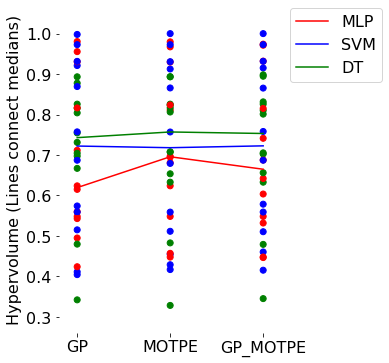

In [18]:
ML_p = ["MLP", "SVM", "DT"]
algorithms = ["GP", "MOTPE", "GP_MOTPE"] 

medians = np.zeros((3, 3))
matrix = final_hv[:,1:]
for i in range(medians.shape[0]):
    factor1 = matrix[matrix[:, 0]==i,:]
    for j in range(medians.shape[1]):
        factor2 = factor1[factor1[:, 1]==j,:]
        m = np.median(factor2, axis=0)
        medians[i, j] = m[2]

fig, ax = plt.subplots(figsize=(4,6))
colors = {0.0:'red', 1:'blue', 2: "green"}
for i in range(3):
    d = matrix[matrix[:,1]==i, :]
    ax.scatter(i*np.ones(len(d)), d[:, 2] , c=pd.Series(d[:, 0]).map(colors))

for m in range(medians.shape[0]):
    plt.plot(medians[m, :], color=colors[m], label=ML_p[m])

plt.legend(bbox_to_anchor=(1, 1.02)) 
plt.xticks([0, 1, 2], algorithms)
plt.ylabel("Hypervolume (Lines connect medians)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(x=0.1, y=0.1)

In [ ]:
final_hv

In [19]:
from scipy.stats import rankdata

ranks = np.zeros((len(datasets_id)*3, 3))
matrix = final_hv
j = 0
data_friedman =np.zeros((ranks.shape[0], 3))
for id_data in datasets_id: #For each dataset
    factor1 = matrix[matrix[:, 0]==id_data, :]
    for i in range(3): # For each ML problem
        factor2 = factor1[factor1[:, 1]==i, :]
        print(factor2[0, 3],",", factor2[1, 3],",", factor2[2, 3])
#         print(rankdata(-factor2[:, 3], method='min'))
        data_friedman[j, :] = factor2[:, 3]
        ranks[j, :] = rankdata(-factor2[:, 3], method='average')
        j +=1

0.9554884057971015 , 0.9672384057971015 , 0.9713061594202897
0.998 , 1.0 , 1.0
0.7311826086956521 , 0.707593115942029 , 0.7024847826086957
0.7115672277860643 , 0.8109041835357625 , 0.7412259393422829
0.9210762483130904 , 0.9125649904112506 , 0.9150916258256978
0.8775553128773351 , 0.893460295475531 , 0.898205305774558
0.5597683982683983 , 0.6237753727753728 , 0.6875461760461761
0.5739627224627226 , 0.4545404040404041 , 0.5783768638768639
0.6669213564213564 , 0.6328059163059163 , 0.6327352092352092
0.5480796586059743 , 0.5480796586059743 , 0.5480796586059743
0.5588392603129445 , 0.5588392603129445 , 0.5589821174558016
0.8040943236469552 , 0.8166622807017545 , 0.80099139741245
0.542776 , 0.6945039999999999 , 0.6419679999999999
0.41121599999999997 , 0.41675199999999996 , 0.41517599999999993
0.6972160000000001 , 0.6535360000000001 , 0.656136
0.6237113756613757 , 0.6808719576719577 , 0.6034806878306878
0.6870428571428571 , 0.6791357142857142 , 0.6870428571428571
0.825668783068783 , 0.825668

[2.125      1.98611111 1.88888889]


Text(0.6888888888888889, 0.03, '(15 wins) GP_MOTPE')

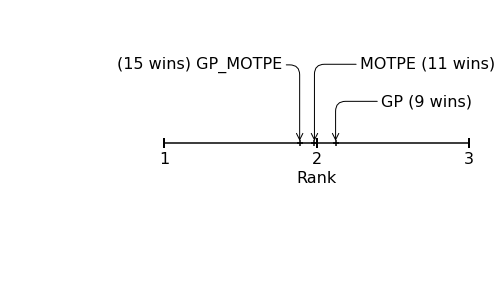

In [20]:
mean_rank = np.mean(ranks, axis=0)
print(mean_rank)
fig, ax = plt.subplots(figsize=(6,5))
plt.plot([1, 3], [0, 0], color='k')
plt.xticks([1, 2, 3], [1, 2, 3])
ax.tick_params(length=10, width=2,direction='inout')
# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.get_yaxis().set_visible(False)

for i in range(len(mean_rank)):
    plt.scatter(mean_rank[i], 0, marker='+', color='k')
plt.xlabel("Rank")
ax.annotate(
'GP (9 wins)',
xy=(mean_rank[0], 0), 
xytext=(mean_rank[0]+.3, .015), 
# bbox=dict(boxstyle="round", fc="0.8"),
arrowprops=dict(arrowstyle="->",
                connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
'MOTPE (11 wins)',
xy=(mean_rank[1], 0), 
xytext=(mean_rank[1]+.3, .03), 
# bbox=dict(boxstyle="round", fc="0.8"),
arrowprops=dict(arrowstyle="->",
                connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
'(15 wins) GP_MOTPE',
xy=(mean_rank[2], 0), 
xytext=(mean_rank[2]-1.2, .03), 
# bbox=dict(boxstyle="round", fc="0.8"),
arrowprops=dict(arrowstyle="->",
                connectionstyle="angle,angleA=0,angleB=90,rad=10"))


In [ ]:
ranks

In [21]:
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as multicomp
import seaborn as sns

ML_p = ["MLP", "SVM", "DT", "sd"]
matrix = final_hv[:,1:]

friedman = stats.friedmanchisquare(data_friedman[:, 0], data_friedman[:, 1], data_friedman[:, 2])
print("Friedman ", str(friedman))
print()

#Statistics test
for i in range(3): #For each ML_problem
    print(ML_p[i])
    factor1 = matrix[matrix[:, 0]==i,:]
    for j in range(0, 3):
        for z in range(1, 3):
            # For each variable Wilcoxon test
            wilcoxon = stats.ranksums(factor1[factor1[:, 1]==j, 2], 
                                     factor1[factor1[:, 1]==z, 2])
            print(j, z, "Wilcoxon (Sig. dif p<0.05): ", str(wilcoxon))
    print()

for j in range(0, 3):
    for z in range(1, 3):
        # For each variable Wilcoxon test
        wilcoxon = stats.ranksums(matrix[matrix[:, 1]==j, 2], 
                                 matrix[matrix[:, 1]==z, 2])
        print(j, z, "Wilcoxon (Sig. dif p<0.05): ", str(wilcoxon))
    
# fig, axn = plt.subplots(figsize=(10,10))
# g4 = sns.heatmap(final_hv[:, 1:], linewidth = 0.5 , cmap = 'vlag', annot=True, fmt=".4",
#                  cbar_kws={'label': 'Hypervolume'}, ax=axn)
# g4.set_xticklabels(["GP", "MOTPE", "GP_MOTPE"])
# g4.set_xlabel("Algorithm")
# g4.set_ylabel("Experiment")
# plt.show()

Friedman  FriedmanchisquareResult(statistic=1.1406249999999645, pvalue=0.5653487396106242)

MLP
0 1 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=-0.5484827557301444, pvalue=0.5833604667027033)
0 2 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=-0.14433756729740643, pvalue=0.8852339144732017)
1 1 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=0.0, pvalue=1.0)
1 2 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=0.4330127018922193, pvalue=0.6650055421020291)
2 1 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=-0.4330127018922193, pvalue=0.6650055421020291)
2 2 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=0.0, pvalue=1.0)

SVM
0 1 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=0.1732050807568877, pvalue=0.8624902301359216)
0 2 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=-0.1732050807568877, pvalue=0.8624902301359216)
1 1 Wilcoxon (Sig. dif p<0.05):  RanksumsResult(statistic=0.0, pvalue=1.0)
1 2 Wilcoxon (Sig. dif p<0.05):  Ranksu

In [22]:
# Overfitting analysis

def overfitting(model_val, model_test):
    pf = pareto_front(model_val, index=True)
    pf_val = np.abs(model_val[pf]) # Compute the PF of the validation set
    pf_test = np.abs(model_test[pf]) # Select the evaluation on test set of those points that were dominant in validation set
    
    abs_dif = pf_val - pf_test
    distance = np.linalg.norm(abs_dif, axis=1)
#     print("distance", distance)
    print(">>", np.mean(distance))
    
    return abs_dif, np.mean(distance)

In [23]:
def plot_overfitting(file_name, val_gp, test_gp, val_motpe, test_motpe, val_gp_motpe, test_gp_motpe, xlim, ylim, showPlot=True):
    [abs_dif1, md1] = overfitting(val_gp, test_gp)          
    [abs_dif2, md2] = overfitting(val_motpe, test_motpe)    
    [abs_dif3, md3] = overfitting(val_gp_motpe, test_gp_motpe)
    
    if showPlot:
        fig, ax = plt.subplots(figsize=(10,10))
        # Move left y-axis and bottim x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        ax.scatter(abs_dif1[:,0], abs_dif1[:,1], label="GP", s=100, marker="s", color='blue')
        ax.scatter(abs_dif2[:,0], abs_dif2[:,1], label="MOTPE", s=90, marker="o", color='orange')
        ax.scatter(abs_dif3[:,0], abs_dif3[:,1], label="GP_MOTPE", s=80, marker="^", color='k')

        plt.xlabel("Error", loc='right')
        plt.ylabel("Recall", loc='top')


    #     ax.set_xlim(xlim)
    #     ax.set_ylim(ylim)
        plt.legend()
    #     plt.savefig(file_name, bbox_inches='tight')
    
    return md1, md2, md3

In [24]:
ML_p = ["MLP", "SVM", "DT"]
dif_val_test = np.zeros((len(datasets_id)*len(ML_p), 3))
dif_train_test = np.zeros((len(datasets_id)*len(ML_p), 3))
algo_dif_val = []
algo_dif_train = []

i = 0
for id_data in datasets_id:
    print(id_data)
    j=0
    for al in ML_p:
        # Differences between val and test
        [md_gp, md_motpe, md_gp_motpe] = plot_overfitting("..\output\plots\overfitting_val_"+al+"_"+str(id_data)+".pdf", 
                                         mlc_functions["GP"][al][id_data]["meanObjectivesVal"], 
                                         mlc_functions["GP"][al][id_data]["meanObjectivesTest"], 
                                         mlc_functions["MOTPE"][al][id_data]["meanObjectivesVal"], 
                                         mlc_functions["MOTPE"][al][id_data]["meanObjectivesTest"], 
                                         mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesVal"], 
                                         mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesTest"], 
                                         xlim=[-0.05, 0.05], ylim=[-0.1, 0.1], showPlot=False)
        dif_val_test[i, :] = np.asarray([md_gp, md_motpe, md_gp_motpe])
        k = np.asarray([[j, 0, md_gp],
                       [j, 1, md_motpe],
                       [j, 2, md_gp_motpe]])
        if len(algo_dif_val) == 0:
            algo_dif_val = k
        else:
            algo_dif_val = np.append(algo_dif_val, k, axis=0)
        
        
        # Differences between train and test
        [md_gp, md_motpe, md_gp_motpe] = plot_overfitting("..\output\plots\overfitting_train_"+al+"_"+str(id_data)+".pdf", 
                                         mlc_functions["GP"][al][id_data]["meanObjectivesTrain"], 
                                         mlc_functions["GP"][al][id_data]["meanObjectivesTest"], 
                                         mlc_functions["MOTPE"][al][id_data]["meanObjectivesTrain"], 
                                         mlc_functions["MOTPE"][al][id_data]["meanObjectivesTest"], 
                                         mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesTrain"], 
                                         mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesTest"], 
                                         xlim=[-0.05, 0.05], ylim=[-0.1, 0.1], showPlot=False)
        dif_train_test[i, :] = np.asarray([md_gp, md_motpe, md_gp_motpe])
        k = np.asarray([[j, 0, md_gp],
                       [j, 1, md_motpe],
                       [j, 2, md_gp_motpe]])
        if len(algo_dif_train) == 0:
            algo_dif_train = k
        else:
            algo_dif_train = np.append(algo_dif_train, k, axis=0)
            
        j += 1
        i += 1


997
>> 0.041500285819600094
>> 0.04028772558021913
>> 0.02729457602613087
>> 0.042510563928892756
>> 0.024894372742025828
>> 0.02702470748221659
>> 0.002
>> 0.0
>> 0.0
>> 0.0
>> 0.0
>> 0.0
>> 0.07557767361729356
>> 0.04197463589911677
>> 0.045668122977513874
>> 0.09501973607505666
>> 0.10851351010710947
>> 0.12863808618222794
841
>> 0.24015172063813273
>> 0.10549787882464177
>> 0.10215988448158678
>> 0.017144854960776734
>> 0.022362484089550206
>> 0.028151256402235904
>> 0.02193114937561207
>> 0.022186915914495318
>> 0.02165846960330529
>> 0.020574800507541118
>> 0.022163923070930906
>> 0.020538825537022333
>> 0.05841394583478761
>> 0.07290417621585805
>> 0.02547631805589823
>> 0.06189833945140344
>> 0.05432217700092956
>> 0.04530805801256494
53
>> 0.5754787900348298
>> 0.7563047668983867
>> 0.6928489037969108
>> 0.055952008967056585
>> 0.08786408783971872
>> 0.07059483158595176
>> 0.1063853255651765
>> 0.10293633654901756
>> 0.09857151042700583
>> 0.0473247073585014
>> 0.0975596341785

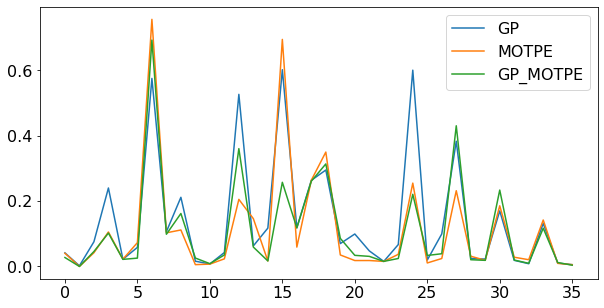

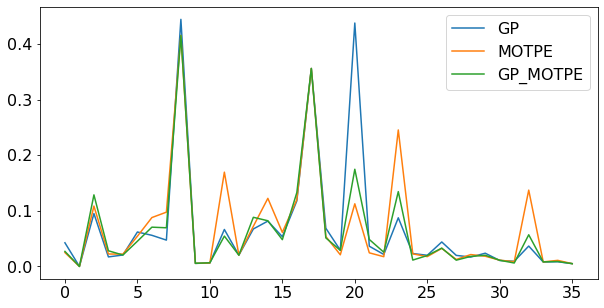

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(dif_val_test[:, 0], label="GP")
plt.plot(dif_val_test[:, 1], label="MOTPE")
plt.plot(dif_val_test[:, 2], label="GP_MOTPE")
plt.legend()

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(dif_train_test[:, 0], label="GP")
plt.plot(dif_train_test[:, 1], label="MOTPE")
plt.plot(dif_train_test[:, 2], label="GP_MOTPE")
plt.legend()

In [26]:
def plot_differences(algo_dif_val, ML_p, algorithms, ylabel="Value", vin=3, vout=3, fs=(4,6), ylim=[0, 1], median=True, path=""):
    medians_dif_val = np.zeros((vin, vout))
    matrix = algo_dif_val
    for i in range(medians_dif_val.shape[0]):
        factor1 = matrix[matrix[:, 0]==i,:]
        for j in range(medians_dif_val.shape[1]):
            factor2 = factor1[factor1[:, 1]==j,:]
            if median:
                m = np.median(factor2, axis=0)
            else:
                m = np.mean(factor2, axis=0)
            medians_dif_val[i, j] = m[2]

    fig, ax = plt.subplots(figsize=fs)
    colors = {0.0:'red', 1:'blue', 2: "green"}
    for i in range(vin):
        d = matrix[matrix[:,1]==i, :]
        ax.scatter(i*np.ones(len(d)), d[:, 2] , c=pd.Series(d[:, 0]).map(colors))

    for m in range(medians_dif_val.shape[0]):
        plt.plot(medians_dif_val[m, :], color=colors[m], label=ML_p[m])

    plt.legend(bbox_to_anchor=(1, 1.02)) 
    plt.xticks(range(len(algorithms)), algorithms)
    additional_text = "medians)" if median else "means)"
    plt.ylabel(ylabel+" (Lines connect "+additional_text)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.margins(x=0.1, y=0.1)
    ax.set_ylim(ylim)
    if len(path)!=0:
        plt.savefig(path, dpi=1200, bbox_inches='tight')

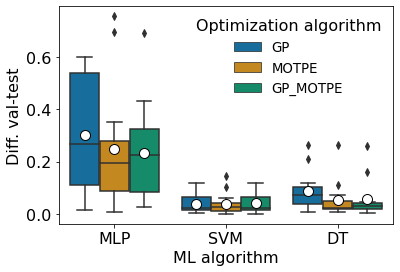

In [44]:
df = pd.DataFrame({
    "ML algorithm": ["MLP" if i==0 else "SVM" if i==1 else "DT" for i in algo_dif_val[:, 0]],
    "Opt. alg" : ["GP" if i==0 else "MOTPE" if i==1 else "GP_MOTPE" for i in algo_dif_val[:, 1]],
    "Diff. val-test": algo_dif_val[:, 2]
})
    
sns.boxplot(y='Diff. val-test', x='ML algorithm', 
                 data=df, 
                 palette="colorblind",
                 hue='Opt. alg', 
           showmeans=True,
           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.legend(title="Optimization algorithm", fontsize='small', fancybox=True, frameon=False)

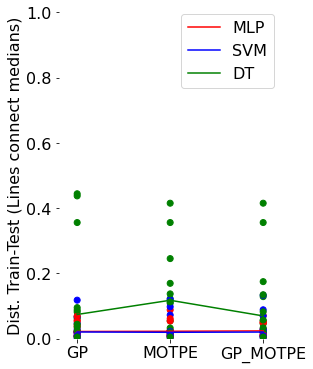

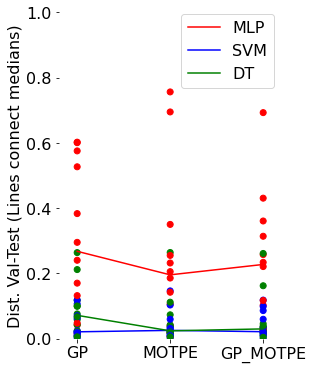

In [27]:
plot_differences(algo_dif_train, ML_p, algorithms, "Dist. Train-Test")
plot_differences(algo_dif_val, ML_p, algorithms, "Dist. Val-Test")

In [ ]:
def generalized_hypervolume(data_val, data_test, ref_point):

    pf = pareto_front(data_val, index=True)
    # Compute the front on validation. This is the combination that the algorithm should suggest to test
    pf_val = data_val[pf]
    # Obtain the evaluation of those solutions that were on the front of validation
    pf_test = data_test[pf]
    # Obtain the new front
    pf = pareto_front(pf_test, index=True)
    pf_test = pf_test[pf]
    
    volumen_val = compute_hypervolume(pf_val, ref_point)
    volumen_test = compute_hypervolume(pf_test, ref_point)
    
    return volumen_val, volumen_test

In [ ]:
generalized_hv = []
ML_p = ["MLP", "SVM", "DT"]
protocols = ["V", "T"]
# 0-MLP, 1-SVM, 2-DT
# 0-GP, 1-MOTPE, 2-GP_MOTPE
ref_point = [1, 0]
dif_hv_GP = np.zeros((len(datasets_id)*len(protocols)*len(ML_p), 3))
dif_hv_MOTPE = np.zeros((len(datasets_id)*len(protocols)*len(ML_p), 3))
dif_hv_GP_MOTPE = np.zeros((len(datasets_id)*len(protocols)*len(ML_p), 3))
dif_violin = []

i=0
for id_data in datasets_id:
    print(id_data)
    
    j=0
    for al in ML_p:
        hv_GP = generalized_hypervolume(mlc_functions["GP"][al][id_data]["meanObjectivesVal"], 
                                      mlc_functions["GP"][al][id_data]["meanObjectivesTest"], 
                                      ref_point)
        
        hv_MOTPE = generalized_hypervolume(mlc_functions["MOTPE"][al][id_data]["meanObjectivesVal"], 
                                      mlc_functions["MOTPE"][al][id_data]["meanObjectivesTest"], 
                                      ref_point)
        
        hv_GP_MOTPE = generalized_hypervolume(mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesVal"], 
                                      mlc_functions["GP_MOTPE"][al][id_data]["meanObjectivesTest"], 
                                      ref_point)
        
        k = np.asarray([[id_data, j, hv_GP[0], hv_MOTPE[0], hv_GP_MOTPE[0], hv_GP[1], hv_MOTPE[1], hv_GP_MOTPE[1]]])
        if len(generalized_hv) == 0:
            generalized_hv = k
        else:
            generalized_hv = np.append(generalized_hv, k, axis=0)
            
        dif_hv_GP[i, :] = np.asarray([j, 0, hv_GP[0]])
        dif_hv_GP[i+1, :] = np.asarray([j, 1, hv_GP[1]])
        
        dif_hv_MOTPE[i, :] = np.asarray([j, 0, hv_MOTPE[0]])
        dif_hv_MOTPE[i+1, :] = np.asarray([j, 1, hv_MOTPE[1]])
        
        dif_hv_GP_MOTPE[i, :] = np.asarray([j, 0, hv_GP_MOTPE[0]])
        dif_hv_GP_MOTPE[i+1, :] = np.asarray([j, 1, hv_GP_MOTPE[1]])
        
        k = np.asarray([
            [j, "GP", hv_GP[1] - hv_GP[0]],
            [j, "MOTPE", hv_MOTPE[1] - hv_MOTPE[0]],
            [j, "GP_MOTPE", hv_GP_MOTPE[1] - hv_GP_MOTPE[0]]
        ])
        if len(dif_violin) == 0:
            dif_violin = k
        else:
            dif_violin = np.append(dif_violin, k, axis=0)
        
        j += 1
        i += 2
df = pd.DataFrame(generalized_hv)
df.to_csv("..\output\generalized_hv.csv")

In [ ]:
plot_differences(dif_hv_GP, ML_p, protocols, "Hypervolume", vin=3, vout=2, fs=(2,6), ylim=[0.3, 1.01], 
                 median=False, path="..\output\plots\diff_val_test_HV_GP.pdf")
plot_differences(dif_hv_MOTPE, ML_p, protocols, "Hypervolume", vin=3, vout=2, fs=(2,6), ylim=[0.3, 1.01], 
                 median=False, path="..\output\plots\diff_val_test_HV_MOTPE.pdf")
plot_differences(dif_hv_GP_MOTPE, ML_p, protocols, "Hypervolume", vin=3, vout=2, fs=(2,6), ylim=[0.3, 1.01], 
                 median=False, path="..\output\plots\diff_val_test_HV_GP_MOTPE.pdf")

In [ ]:
j=0
for al in ML_p:
    temp_GP = dif_hv_GP[dif_hv_GP[:,0]==j, :] 
    temp_MOTPE = dif_hv_MOTPE[dif_hv_MOTPE[:,0]==j, :] 
    temp_GP_MOTPE = dif_hv_GP_MOTPE[dif_hv_GP_MOTPE[:,0]==j, :] 
    
    gp_tile = np.tile(0, temp_GP.shape[0])
    temp_GP[:, 0] = gp_tile

    motpe_tile = np.tile(1, temp_MOTPE.shape[0])
    temp_MOTPE[:, 0] = motpe_tile

    gp_motpe_tile = np.tile(2, temp_GP_MOTPE.shape[0])
    temp_GP_MOTPE[:, 0] = gp_motpe_tile

    dif_val_test_HV = np.append(temp_GP, temp_MOTPE, axis=0)
    dif_val_test_HV = np.append(dif_val_test_HV, temp_GP_MOTPE, axis=0)
    
    plot_differences(dif_val_test_HV, algorithms, protocols, "Hypervolume", vin=3, vout=2, fs=(2,6), ylim=[0.3, 1.01], 
                 median=False, path="..\output\plots\diff_val_test_HV"+str(j)+".pdf")
    
    j += 1

In [ ]:
# dif_hv_GP_new = np.tile(0, dif_hv_GP.shape[0])
# dif_hv_GP[:, 0] = dif_hv_GP_new

# dif_hv_MOTPE_new = np.tile(1, dif_hv_MOTPE.shape[0])
# dif_hv_MOTPE[:, 0] = dif_hv_MOTPE_new

# dif_hv_GP_MOTPE_new = np.tile(2, dif_hv_GP_MOTPE.shape[0])
# dif_hv_GP_MOTPE[:, 0] = dif_hv_GP_MOTPE_new

# dif_val_test_HV = np.append(dif_hv_GP, dif_hv_MOTPE, axis=0)
# dif_val_test_HV = np.append(dif_val_test_HV, dif_hv_GP_MOTPE, axis=0)

In [ ]:
# plot_differences(dif_val_test_HV, algorithms, protocols, "Hypervolume", vin=3, vout=2, fs=(2,6), ylim=[0.3, 1.01], 
#                  median=False, path="..\output\plots\diff_val_test_HV.pdf")

In [ ]:
import seaborn as sns
for mlp in range(len(ML_p)):
    matrix =  dif_violin[dif_violin[:, 0]==str(mlp), 1:]
    df = pd.DataFrame(matrix, columns=["Algorithms","HV. Diff."])
    df = df.astype({"Algorithms": str, "HV. Diff.": float})
    
#     fig, ax = plt.subplots(figsize=(10,5))
    sns.displot(df, x="HV. Diff.", hue="Algorithms", kind="kde")